In [1]:
import pandas as pd
import numpy as np
import keras
import scipy
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.model_selection import GroupKFold
from sklearn import linear_model
from lineartree import RandomForestRegressor
from sklearn import metrics
from scipy.signal import savgol_filter
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [2]:
from numpy.random import seed
seed(1)
from tensorflow.keras.utils import set_random_seed
set_random_seed(2)

In [3]:
def rae(actual, predicted):
    actual = np.asarray(actual).reshape(-1,1)
    predicted = np.asarray(predicted).reshape(-1,1)
    numerator = np.sum(np.abs(predicted - actual))
    denominator = np.sum(np.abs(np.mean(actual) - actual))
    return numerator / denominator

In [4]:
def peak_eV_nm(peak_eV):
    peak_eV = np.asarray(peak_eV).reshape(-1,1)
    return 1239.84193/peak_eV

In [5]:
def FWHM_eV_nm(peak_eV,fwhm_eV):
    peak_eV = np.asarray(peak_eV).reshape(-1,1)
    fwhm_eV = np.asarray(fwhm_eV).reshape(-1,1)
    return  2*(1239.84193/(peak_eV-fwhm_eV/2) - 1239.84193/(peak_eV))

In [6]:
def predict_dist(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.hstack(preds)

In [7]:
def predict_point(X, model, num_samples):
    pred_dist = predict_dist(X, model, num_samples)
    return pred_dist.mean(axis=1)

In [8]:
#Define models

initializer = keras.initializers.HeNormal(seed=1)
opt = keras.optimizers.Adam(learning_rate=0.001)

model_peak = keras.models.Sequential()
model_peak.add(Dense(5, input_shape=(5,), kernel_initializer=initializer, activation='relu'))
model_peak.add(Dense(50,  activation='relu'))
model_peak.add(keras.layers.Dropout(0.2))
model_peak.add(Dense(50,  activation='relu'))
model_peak.add(keras.layers.Dropout(0.2))
model_peak.add(Dense(1, kernel_initializer=initializer))
# Compile model
model_peak.compile(loss='mean_squared_error', optimizer= opt)

model_fwhm = keras.models.Sequential()
model_fwhm.add(Dense(5, input_shape=(5,), kernel_initializer=initializer, activation='relu'))
model_fwhm.add(Dense(50,  activation='relu'))
model_fwhm.add(keras.layers.Dropout(0.2))
model_fwhm.add(Dense(50,  activation='relu'))
model_fwhm.add(keras.layers.Dropout(0.2))
model_fwhm.add(Dense(1, kernel_initializer=initializer))
# Compile model
model_fwhm.compile(loss='mean_squared_error', optimizer= opt)

model_cascade = keras.models.Sequential()
model_cascade.add(Dense(6, input_shape=(6,), kernel_initializer=initializer, activation='relu'))
model_cascade.add(Dense(50,  activation='relu'))
model_cascade.add(keras.layers.Dropout(0.2))
model_cascade.add(Dense(50,  activation='relu'))
model_cascade.add(keras.layers.Dropout(0.2))
model_cascade.add(Dense(1, kernel_initializer=initializer))
# Compile model
model_cascade.compile(loss='mean_squared_error', optimizer= opt)

In [9]:
#Train model on entire dataset (Absorbance)
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

matrix = np.zeros([1,8])
matrix_fwhm = np.zeros([1,8])
matrix_cascade = np.zeros([1,8])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
X2_test = X2
y_test = y
z_test = z
j=0

#Initialize with fixed weights
model_peak.load_weights('initialize_weights3.h5')
model_fwhm.load_weights('initialize_weights3.h5')
model_cascade.load_weights('initialize_weights4.h5')

#Train models
#prediction for Peak
model_peak.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test),verbose = 1, use_multiprocessing=False, workers = 100)
y_pred = model_peak.predict(X_test)
#prediction for FWHM (direct)
model_fwhm.fit(X_train, z_train, epochs=300, validation_data=(X_test, z_test),verbose = 1, use_multiprocessing=False, workers = 100)
y_pred_fwhm = model_fwhm.predict(X_test)
#prediction for FWHM (cascade)
model_cascade.fit(X2_train, z_train, epochs=300, validation_data=(X2_test, z_test),verbose = 1, use_multiprocessing=False, workers = 100)
X_test.insert(5, "Peak_eV", model_peak.predict(X_test), True)
y_pred_cascade = model_cascade.predict(X_test)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Training Accuracy (no dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

# serialize weights to HDF5
#model_peak.save_weights("Emi_peak_1000.h5")
#model_fwhm.save_weights("Emi_fwhm_1000.h5")
#model_cascade.save_weights("Emi_cascade_1000.h5")

Epoch 1/300
159/159 [==============================] - 1s 3ms/step - loss: 0.0366 - val_loss: 0.0186
Epoch 2/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0162
Epoch 3/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0184 - val_loss: 0.0151
Epoch 4/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0169 - val_loss: 0.0145
Epoch 5/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0161 - val_loss: 0.0145
Epoch 6/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0157 - val_loss: 0.0140
Epoch 7/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0155 - val_loss: 0.0137
Epoch 8/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0138
Epoch 9/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 0.0136
Epoch 10/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0151 - val_lo

Epoch 161/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 162/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0116
Epoch 163/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0114
Epoch 164/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0113
Epoch 165/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0116
Epoch 166/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0114
Epoch 167/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0116
Epoch 168/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0115
Epoch 169/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0114
Epoch 170/300
159/159 [==============================] - 0s 2ms/step - lo

159/159 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 20/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 21/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 22/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 23/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 24/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 25/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 26/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 27/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 28/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 

159/159 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 179/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 180/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 181/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 182/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 183/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 184/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 185/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 186/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 187/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0016 - v

159/159 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 37/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 38/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 39/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 40/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 41/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 42/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 43/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 44/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 45/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 

159/159 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 196/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 197/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 198/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 199/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 200/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 201/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 202/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 203/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 204/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0016 - v

In [10]:
#Predictions with dropout

# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

matrix = np.zeros([1,8])
matrix_fwhm = np.zeros([1,8])
matrix_cascade = np.zeros([1,8])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
y_test = y
z_test = z

X_test_t = K.constant(X_test)

#prediction for Peak
y_pred =  predict_point(X_test_t, model_peak, 1000)
#prediction for FWHM (direct)
y_pred_fwhm = predict_point(X_test_t, model_fwhm, 1000)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", y_pred, True)
X_test_t = K.constant(X_test)
y_pred_cascade = predict_point(X_test_t, model_cascade, 1000)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Training Accuracy (with dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

Absorption Peak/FWHM Training Accuracy (with dropout at inference)
Absorbance Peak
MAE (eV):	 0.0920
R2 (eV):	 0.6330
RAE (eV):	 0.5924
RMSE (eV):	 0.1164
MAE (nm):	 21.1135
R2 (nm):	 0.6177
RAE (nm):	 0.6001
RMSE (nm):	 26.7701
Absorbance FWHM (direct)
MAE (eV):	 0.0093
R2 (eV):	 0.6614
RAE (eV):	 0.5482
RMSE (eV):	 0.0128
MAE (nm):	 3.5506
R2 (nm):	 0.5548
RAE (nm):	 0.6551
RMSE (nm):	 4.6310
Absorbance FWHM (cascade)
MAE (eV):	 0.0090
R2 (eV):	 0.6699
RAE (eV):	 0.5311
RMSE (eV):	 0.0126
MAE (nm):	 3.5317
R2 (nm):	 0.5582
RAE (nm):	 0.6516
RMSE (nm):	 4.6135


In [11]:
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

background = X.sample(n = 500)
background2 = X2.sample(n = 500)

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/5088 [00:00<?, ?it/s]

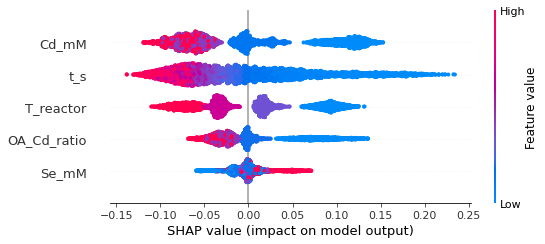

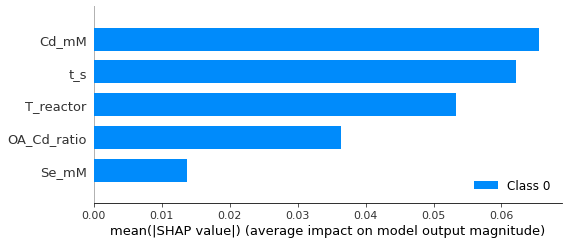

In [12]:
#SHAP on training data for Peak
import shap
explainer = shap.KernelExplainer(model_peak, background)
shap_values1 = explainer.shap_values(X)
shap.summary_plot(shap_values1[0], X)
shap.summary_plot(shap_values1, X, plot_type="bar")

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/5088 [00:00<?, ?it/s]

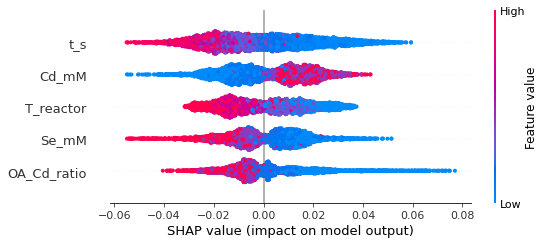

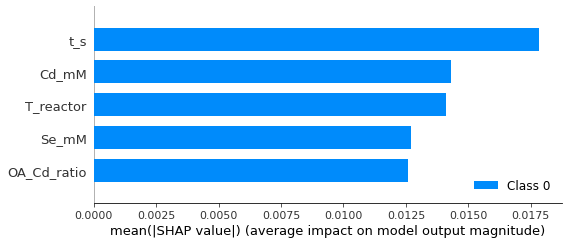

In [13]:
#SHAP on training data for FWHM
explainer = shap.KernelExplainer(model_fwhm, background)
shap_values2 = explainer.shap_values(X)
shap.summary_plot(shap_values2[0], X)
shap.summary_plot(shap_values2, X, plot_type="bar")

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/5088 [00:00<?, ?it/s]

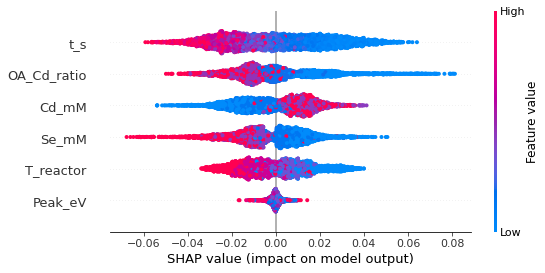

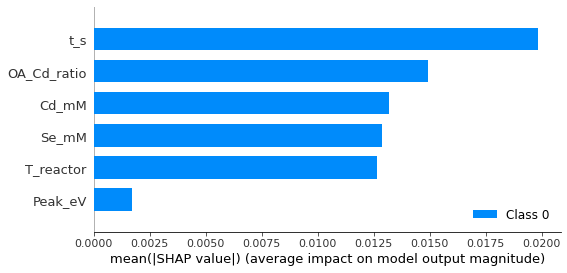

In [14]:
#SHAP on training data for FWHM (cascade)
explainer = shap.KernelExplainer(model_cascade, background2)
shap_values3 = explainer.shap_values(X2)
shap.summary_plot(shap_values3[0], X2)
shap.summary_plot(shap_values3, X2, plot_type="bar")

In [15]:
#Test NN on interpolation without dropout, PL Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe PL Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z


#prediction for Peak
y_pred = model_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = model_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", model_peak.predict(X_test), True)
y_pred_cascade = model_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Interpolation (no dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test = y_test.to_numpy().reshape(1,-1)
z_test = z_test.to_numpy().reshape(1,-1)
y_pred = y_pred.reshape(1,-1)
y_pred_fwhm = y_pred_fwhm.reshape(1,-1)
y_pred_cascade = y_pred_cascade.reshape(1,-1)

np.savetxt("NN_PL_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("NN_PL_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("NN_PL_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

15/15 [==============================] - 0s 712us/step
Absorption Peak/FWHM Interpolation (no dropout at inference)
Absorbance Peak
MAE (eV):	 0.0221
R2 (eV):	 0.9527
RAE (eV):	 0.1839
RMSE (eV):	 0.0309
MAE (nm):	 4.9234
R2 (nm):	 0.9576
RAE (nm):	 0.1789
RMSE (nm):	 6.6055
Absorbance FWHM (direct)
MAE (eV):	 0.0095
R2 (eV):	 0.5525
RAE (eV):	 0.5563
RMSE (eV):	 0.0156
MAE (nm):	 2.3017
R2 (nm):	 0.6401
RAE (nm):	 0.4874
RMSE (nm):	 3.6435
Absorbance FWHM (cascade)
MAE (eV):	 0.0085
R2 (eV):	 0.6106
RAE (eV):	 0.5012
RMSE (eV):	 0.0145
MAE (nm):	 1.9912
R2 (nm):	 0.7267
RAE (nm):	 0.4216
RMSE (nm):	 3.1754


In [16]:
#Test NN on interpolation with dropout, PL Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe PL Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

X_test_t = K.constant(X_test)

#prediction for Peak
y_pred =  predict_point(X_test_t, model_peak, 1000)
#prediction for FWHM (direct)
y_pred_fwhm = predict_point(X_test_t, model_fwhm, 1000)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", y_pred, True)
X_test_t = K.constant(X_test)
y_pred_cascade = predict_point(X_test_t, model_cascade, 1000)

matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Interpolation (with dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test = y_test.to_numpy().reshape(1,-1)
z_test = z_test.to_numpy().reshape(1,-1)
y_pred = y_pred.reshape(1,-1)
y_pred_fwhm = y_pred_fwhm.reshape(1,-1)
y_pred_cascade = y_pred_cascade.reshape(1,-1)

np.savetxt("MCNN_PL_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("MCNN_PL_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("MCNN_PL_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Interpolation (with dropout at inference)
Absorbance Peak
MAE (eV):	 0.0219
R2 (eV):	 0.9536
RAE (eV):	 0.1821
RMSE (eV):	 0.0306
MAE (nm):	 4.8696
R2 (nm):	 0.9583
RAE (nm):	 0.1770
RMSE (nm):	 6.5472
Absorbance FWHM (direct)
MAE (eV):	 0.0096
R2 (eV):	 0.5526
RAE (eV):	 0.5648
RMSE (eV):	 0.0156
MAE (nm):	 2.3314
R2 (nm):	 0.6431
RAE (nm):	 0.4937
RMSE (nm):	 3.6286
Absorbance FWHM (cascade)
MAE (eV):	 0.0087
R2 (eV):	 0.6041
RAE (eV):	 0.5086
RMSE (eV):	 0.0146
MAE (nm):	 2.0005
R2 (nm):	 0.7234
RAE (nm):	 0.4236
RMSE (nm):	 3.1943


In [17]:
#Test Linear model on extrapolation, PL Peak, FWHM (eV)

#Test data set (extrapolation)
df2 = pd.read_csv('CdSe PL Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = model_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = model_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", model_peak.predict(X_test), True)
y_pred_cascade = model_cascade.predict(X_test)

matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Extrapolation (no dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test = y_test.to_numpy().reshape(1,-1)
z_test = z_test.to_numpy().reshape(1,-1)
y_pred = y_pred.reshape(1,-1)
y_pred_fwhm = y_pred_fwhm.reshape(1,-1)
y_pred_cascade = y_pred_cascade.reshape(1,-1)

np.savetxt("NN_PL_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("NN_PL_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("NN_PL_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

13/13 [==============================] - 0s 1ms/step
Absorption Peak/FWHM Extrapolation (no dropout at inference)
Absorbance Peak
MAE (eV):	 0.0393
R2 (eV):	 0.8861
RAE (eV):	 0.3175
RMSE (eV):	 0.0489
MAE (nm):	 9.3927
R2 (nm):	 0.8802
RAE (nm):	 0.3228
RMSE (nm):	 11.7233
Absorbance FWHM (direct)
MAE (eV):	 0.0116
R2 (eV):	 0.2026
RAE (eV):	 0.6591
RMSE (eV):	 0.0181
MAE (nm):	 2.6611
R2 (nm):	 0.0805
RAE (nm):	 0.7113
RMSE (nm):	 4.2863
Absorbance FWHM (cascade)
MAE (eV):	 0.0131
R2 (eV):	 0.2102
RAE (eV):	 0.7459
RMSE (eV):	 0.0181
MAE (nm):	 3.0645
R2 (nm):	 0.0535
RAE (nm):	 0.8192
RMSE (nm):	 4.3487


In [18]:
#Test NN on interpolation with dropout, PL Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe PL Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

X_test_t = K.constant(X_test)

#prediction for Peak
y_pred =  predict_point(X_test_t, model_peak, 1000)
#prediction for FWHM (direct)
y_pred_fwhm = predict_point(X_test_t, model_fwhm, 1000)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", y_pred, True)
X_test_t = K.constant(X_test)
y_pred_cascade = predict_point(X_test_t, model_cascade, 1000)

matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Extrapolation (with dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test = y_test.to_numpy().reshape(1,-1)
z_test = z_test.to_numpy().reshape(1,-1)
y_pred = y_pred.reshape(1,-1)
y_pred_fwhm = y_pred_fwhm.reshape(1,-1)
y_pred_cascade = y_pred_cascade.reshape(1,-1)

np.savetxt("MCNN_PL_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("MCNN_PL_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("MCNN_PL_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Extrapolation (with dropout at inference)
Absorbance Peak
MAE (eV):	 0.0392
R2 (eV):	 0.8869
RAE (eV):	 0.3164
RMSE (eV):	 0.0488
MAE (nm):	 9.3970
R2 (nm):	 0.8797
RAE (nm):	 0.3230
RMSE (nm):	 11.7475
Absorbance FWHM (direct)
MAE (eV):	 0.0116
R2 (eV):	 0.2223
RAE (eV):	 0.6604
RMSE (eV):	 0.0179
MAE (nm):	 2.6667
R2 (nm):	 0.1088
RAE (nm):	 0.7128
RMSE (nm):	 4.2197
Absorbance FWHM (cascade)
MAE (eV):	 0.0145
R2 (eV):	 0.0441
RAE (eV):	 0.8236
RMSE (eV):	 0.0199
MAE (nm):	 3.3621
R2 (nm):	 -0.1438
RAE (nm):	 0.8987
RMSE (nm):	 4.7807
